# Preprocessing Pipeline
### Standarization: transform (rescale) the test data with training data statistics
    -> StandardScaler (remove the mean and divide it by standard deviation)
    -> MinMaxScaler (rescale the data to be of [0,1] range, meant for data with small variance which will result in a very close dataset if use the standard scaler )
    -> MaxabsScaler (...[-1,1] ..., meant for scaling sparse data, which is already centered at 0, without breaking the sparseness)
    -> RobustScaler (Scale features using statistics that are robust to outliers. This Scaler removes the median and scales the data according to the quantile range, which are less influenced by outliers)
    -> sklearn.decomposition.PCA (remove the linear correlation across features)
### Non-linear transformation: 
    -> QuantileTransformer (provides a non-parametric transformation based on the quantile function to map the data to a uniform distribution with values between 0 and 1)
### Normalization
    -> Normalizer (Normalize samples individually to unit norm, that is norm =1， Scaling inputs to unit norms is a common operation for text classification or clustering, because the dot product will be the similarity of the two vector using cosine metrics)  
### Binerization
    -> Binarizer (thresholding numerical features to get boolean values, >=a => 1, <a => 0)
### Encoding categorical features
    -> OneHotEncoder()
### Imputation of  missing values
    -> Imputer (The Imputer class provides basic strategies for imputing missing values, either using the mean, the median or the most frequent value of the row or column in which the missing values are located.)
### Generating polynomial features
    -> PolynomialFeatures (get features’ high-order and interaction terms)
### Custom transforms
    -> FunctionTransformers (convert an existing Python function into a transformer to assist in data cleaning or processing)

In [ ]:
# pipeline
#http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

In [4]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction import DictVectorizer

from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

from copy import deepcopy
from math import ceil


import pandas as pd
import math
import numpy as np
from pandas import Series

/Users/Amanda/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# load data and drop fileds
data = pd.read_csv('./data/ConversionDataNew_clean.csv')
#data = data.drop(['Unnamed: 0','Attributions: Unified Tracking Entry Referrer Clean','Attributions: Unified Tracking Entry Path Clean',],axis=1)
data.columns

/Users/Amanda/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2,3,5,7,8,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['Unnamed: 0', 'Users Minimum Number of Months', 'Users Created Date',
       'Sales Transactions Transaction Date',
       'Sales Transactions Storage Plan Tier',
       'Sales Transactions Storage Plan Max Cubic Feet',
       'Sales Transactions Storage Plan Category',
       'Sales Transactions Storage Plan', 'Sales Transactions Ops Sector',
       'Leads Zip Code', 'Leads Lead Age In Days At Gross Conversion',
       'Leads Created Date', 'Leads Intended Storage Duration Tiers',
       'Leads Intended Storage Duration In Months',
       'Leads Has Storage Plan Quote (Yes / No)',
       'Leads Is Chat Lead (Yes / No)',
       'Leads Is Intended Storage Term Greater Than or Equal to 12 Months (Yes / No)',
       'Sales Transactions Is Gross Conversion (Yes / No)',
       'Sales Transactions Application Category',
       'Attributions: Unified Tracking Converted Same Week First Seen (Yes / No)',
       'Attributions: Unified Tracking Unified Ops Sector',
       'Attributions: Un

In [3]:
len(data)

112869

In [63]:
# Create Metadata Table
def meta_table(data):
    meta_data = pd.DataFrame(columns=['filed','missing_value_percent','value_type','distinct_number','encoding'])
    meta_data['filed'] = data.columns
    missing_percent = list()
    for c in data.columns:
        missing_percent.append((len(data[Series.isnull(data[c])])*1.0)/ len(data))
    meta_data['missing_value_percent'] = missing_percent

    value_type = list()
    for c in data.columns:
        if c in ['Leads Lead Age In Days At Gross Conversion','Leads Intended Storage Duration In Months']:
            value_type.append('Num')
        elif c in ['Users Created Date','Leads Created Date','Sales Transactions Transaction Date']:
            value_type.append('Date')
        else:
            value_type.append('Cat')
    meta_data['value_type'] = value_type

    distinct_num = list()
    for c in data.columns:
        distinct_num.append(len(data[c].unique()))
    meta_data['distinct_number'] = distinct_num
    return meta_data

In [125]:
meta_table_whole = meta_table(data)
np.mean(meta_table_whole['missing_value_percent'])

0.30368026858831143

In [3]:
#filter out leads from web and app -- almost half
data_filtered = data[data['Leads Intended Storage Duration Tiers'] != 'Undefined']
data_filtered = data_filtered[(data_filtered['Leads Intended Storage Duration In Months'] != '11,231')
                             & (data_filtered['Leads Intended Storage Duration In Months'] != '11,211')]                
len(data_filtered)

61685

In [4]:
# recalc metadata table
meta_table_filtered = meta_table(data_filtered)
np.mean(meta_table_filtered['missing_value_percent'])

NameError: name 'meta_table' is not defined

In [128]:
meta_table_filtered

,filed,missing_value_percent,value_type,distinct_number,encoding
0,Users Minimum Number of Months,0.737246,Cat,3,NaN
1,Users Created Date,0.108422,Date,636,NaN
2,Sales Transactions Transaction Date,0.737246,Date,556,NaN
3,Sales Transactions Storage Plan Tier,0.000000,Cat,4,NaN
4,Sales Transactions Storage Plan Max Cubic Feet,0.737246,Cat,25,NaN
5,Sales Transactions Storage Plan Category,0.000000,Cat,3,NaN
6,Sales Transactions Storage Plan,0.737246,Cat,25,NaN
7,Sales Transactions Ops Sector,0.737246,Cat,5,NaN
8,Leads Zip Code,0.016422,Cat,1480,NaN
9,Leads Lead Age In Days At Gross Conversion,0.539434,Num,298,NaN


In [5]:
#Gross Conversion Prediction:
#Drop unnecessary or too informative fields:
model_fields = ['Leads Zip Code','Leads Created Date Month','Leads Created Date Weekday','Leads Created Date Season','Leads Has Storage Plan Quote (Yes / No)'
               ,'Leads Intended Storage Duration In Months','Leads Is Chat Lead (Yes / No)'
               ,'Attributions: Unified Tracking Unified Ops Sector','Attributions: Unified Tracking Entry Referrer Domain'
               ,'Attributions: Unified Tracking Entry Path Clean 1','Attributions: Unified Tracking UTM Medium Categories'
               ,'Sales Transactions Is Gross Conversion (Yes / No)']
data_model = data_filtered[model_fields]
data_model.head()

,Leads Zip Code,Leads Created Date Month,Leads Created Date Weekday,Leads Created Date Season,Leads Has Storage Plan Quote (Yes / No),Leads Intended Storage Duration In Months,Leads Is Chat Lead (Yes / No),Attributions: Unified Tracking Unified Ops Sector,Attributions: Unified Tracking Entry Referrer Domain,Attributions: Unified Tracking Entry Path Clean 1,Attributions: Unified Tracking UTM Medium Categories,Sales Transactions Is Gross Conversion (Yes / No)
2,11224.0,10.0,3.0,4.0,No,123,No,New York,facebook,nyc,Paid Social/ Display,No
3,60610.0,8.0,0.0,3.0,No,120,No,Chicago,google,NaN,Organic/ No UTM,Yes
4,60610.0,8.0,0.0,3.0,No,120,No,Chicago,google,NaN,Organic/ No UTM,No
5,10023.0,12.0,3.0,1.0,No,120,No,New York,NaN,NaN,No attribution data,No
6,11218.0,6.0,0.0,2.0,No,100,No,New York,NaN,NaN,Organic/ No UTM,No


In [130]:
meta_table(data_model)

,filed,missing_value_percent,value_type,distinct_number,encoding
0,Leads Zip Code,0.016422,Cat,1480,NaN
1,Leads Created Date Month,0.000000,Cat,12,NaN
2,Leads Created Date Weekday,0.000000,Cat,7,NaN
3,Leads Created Date Season,0.000000,Cat,4,NaN
4,Leads Has Storage Plan Quote (Yes / No),0.000000,Cat,2,NaN
5,Leads Intended Storage Duration In Months,0.000000,Num,41,NaN
6,Leads Is Chat Lead (Yes / No),0.000000,Cat,2,NaN
7,Attributions: Unified Tracking Unified Ops Sector,0.009305,Cat,5,NaN
8,Attributions: Unified Tracking Entry Referrer ...,0.471136,Cat,73,NaN
9,Attributions: Unified Tracking Entry Path Clean 1,0.581762,Cat,40,NaN


In [6]:
# recalc metadata table
meta_table_model = meta_table(data_model)
np.mean(meta_table_model['missing_value_percent'])

NameError: name 'meta_table' is not defined

In [28]:
data_external = pd.read_csv('data/External_data_Merged.csv')
data_external.head()

,Zipcode,Mean,Median,Population,Homevalue
0,601,22496.33333,13144.33333,NaN,NaN
1,602,15078.40000,11323.60000,NaN,NaN
2,603,26046.80000,15386.40000,NaN,NaN
3,605,27497.50000,9461.00000,NaN,NaN
4,606,19194.00000,15233.00000,NaN,NaN


In [133]:
meta_table(data_external)

,filed,missing_value_percent,value_type,distinct_number,encoding
0,Zipcode,0.000000,Cat,14803,NaN
1,Mean,0.000000,Cat,14139,NaN
2,Median,0.000000,Cat,13271,NaN
3,Population,0.025265,Cat,12024,NaN
4,Homevalue,0.795920,Cat,2649,NaN


In [8]:
#data merge:
data_merged = pd.merge(data_model, data_external, left_on = 'Leads Zip Code', right_on = 'Zipcode',
      how='left')

In [9]:
len(data_merged)

61685

In [136]:
np.mean(meta_table(data_merged)['missing_value_percent'])

0.09015920545084373

In [10]:
data_merged = data_merged.drop(['Leads Zip Code', 'Zipcode'],axis=1)

In [11]:
data_merged.head()

,Leads Created Date Month,Leads Created Date Weekday,Leads Created Date Season,Leads Has Storage Plan Quote (Yes / No),Leads Intended Storage Duration In Months,Leads Is Chat Lead (Yes / No),Attributions: Unified Tracking Unified Ops Sector,Attributions: Unified Tracking Entry Referrer Domain,Attributions: Unified Tracking Entry Path Clean 1,Attributions: Unified Tracking UTM Medium Categories,Sales Transactions Is Gross Conversion (Yes / No),Mean,Median,Population,Homevalue
0,10.0,3.0,4.0,No,123,No,New York,facebook,nyc,Paid Social/ Display,No,50343.57143,36407.14286,47621.0,370.866667
1,8.0,0.0,3.0,No,120,No,Chicago,google,NaN,Organic/ No UTM,Yes,106976.90000,109917.00000,37726.0,310.316667
2,8.0,0.0,3.0,No,120,No,Chicago,google,NaN,Organic/ No UTM,No,106976.90000,109917.00000,37726.0,310.316667
3,12.0,3.0,1.0,No,120,No,New York,NaN,NaN,No attribution data,No,142738.25000,141201.50000,60998.0,1484.633333
4,6.0,0.0,2.0,No,100,No,New York,NaN,NaN,Organic/ No UTM,No,75578.80000,67092.20000,75220.0,556.366667


In [12]:
data_merged.columns

Index(['Leads Created Date Month', 'Leads Created Date Weekday',
       'Leads Created Date Season', 'Leads Has Storage Plan Quote (Yes / No)',
       'Leads Intended Storage Duration In Months',
       'Leads Is Chat Lead (Yes / No)',
       'Attributions: Unified Tracking Unified Ops Sector',
       'Attributions: Unified Tracking Entry Referrer Domain',
       'Attributions: Unified Tracking Entry Path Clean 1',
       'Attributions: Unified Tracking UTM Medium Categories',
       'Sales Transactions Is Gross Conversion (Yes / No)', 'Mean', 'Median',
       'Population', 'Homevalue'],
      dtype='object')

In [13]:
num_columns = ['Mean','Median','Population','Homevalue']
cat_columns = list(set(data_merged.columns) - set(num_columns) - set('Leads Intended Storage Duration In Months'))
cat_columns,num_columns

(['Attributions: Unified Tracking Entry Referrer Domain',
  'Attributions: Unified Tracking Entry Path Clean 1',
  'Leads Has Storage Plan Quote (Yes / No)',
  'Attributions: Unified Tracking UTM Medium Categories',
  'Leads Created Date Weekday',
  'Leads Created Date Month',
  'Leads Created Date Season',
  'Sales Transactions Is Gross Conversion (Yes / No)',
  'Leads Intended Storage Duration In Months',
  'Leads Is Chat Lead (Yes / No)',
  'Attributions: Unified Tracking Unified Ops Sector'],
 ['Mean', 'Median', 'Population', 'Homevalue'])

In [141]:
meta_table(data_merged)

,filed,missing_value_percent,value_type,distinct_number,encoding
0,Leads Created Date Month,0.000000,Cat,12,NaN
1,Leads Created Date Weekday,0.000000,Cat,7,NaN
2,Leads Created Date Season,0.000000,Cat,4,NaN
3,Leads Has Storage Plan Quote (Yes / No),0.000000,Cat,2,NaN
4,Leads Intended Storage Duration In Months,0.000000,Num,41,NaN
5,Leads Is Chat Lead (Yes / No),0.000000,Cat,2,NaN
6,Attributions: Unified Tracking Unified Ops Sector,0.009305,Cat,5,NaN
7,Attributions: Unified Tracking Entry Referrer ...,0.471136,Cat,73,NaN
8,Attributions: Unified Tracking Entry Path Clean 1,0.581762,Cat,40,NaN
9,Attributions: Unified Tracking UTM Medium Cate...,0.000000,Cat,5,NaN


In [14]:
np.mean(temp['Mean'])

NameError: name 'temp' is not defined

In [148]:
#missing value imputation:
temp = deepcopy(data_merged)
def missing_value_imputer(row):
    for c in cat_columns:
        if str(row[c])== 'nan':
            row[c] = 'missing'
        else:
            row[c] = row[c]
    for n in num_columns:
        if str(row[n])=='nan':
            row[n] = np.mean(temp[n])
        else:
            row[n] = row[n]
    return row
data_model = data_merged.apply(missing_value_imputer,axis = 1)
data_model

,Leads Created Date Month,Leads Created Date Weekday,Leads Created Date Season,Leads Has Storage Plan Quote (Yes / No),Leads Intended Storage Duration In Months,Leads Is Chat Lead (Yes / No),Attributions: Unified Tracking Unified Ops Sector,Attributions: Unified Tracking Entry Referrer Domain,Attributions: Unified Tracking Entry Path Clean 1,Attributions: Unified Tracking UTM Medium Categories,Sales Transactions Is Gross Conversion (Yes / No),Mean,Median,Population,Homevalue
0,10.0,3.0,4.0,No,123,No,New York,facebook,nyc,Paid Social/ Display,No,50343.571430,36407.142860,47621.000000,370.866667
1,8.0,0.0,3.0,No,120,No,Chicago,google,missing,Organic/ No UTM,Yes,106976.900000,109917.000000,37726.000000,310.316667
2,8.0,0.0,3.0,No,120,No,Chicago,google,missing,Organic/ No UTM,No,106976.900000,109917.000000,37726.000000,310.316667
3,12.0,3.0,1.0,No,120,No,New York,missing,missing,No attribution data,No,142738.250000,141201.500000,60998.000000,1484.633333
4,6.0,0.0,2.0,No,100,No,New York,missing,missing,Organic/ No UTM,No,75578.800000,67092.200000,75220.000000,556.366667
5,3.0,3.0,2.0,No,99,No,New York,missing,missing,No attribution data,No,81335.333330,71292.333330,36688.000000,489.683333
6,12.0,4.0,1.0,No,99,No,New York,missing,missing,No attribution data,No,81182.553643,92708.879652,47990.566821,512.513739
7,12.0,0.0,1.0,No,99,No,New York,missing,missing,No attribution data,No,81182.553643,92708.879652,47990.566821,512.513739
8,6.0,2.0,2.0,No,84,No,"Washington, DC",missing,missing,Organic/ No UTM,No,70506.000000,37486.000000,12775.000000,629.616667
9,4.0,3.0,2.0,No,72,No,New York,missing,missing,Paid Social/ Display,No,75312.250000,244371.250000,59129.000000,293.850000


In [149]:
meta_table_model = meta_table(data_model)
np.mean(meta_table_model['missing_value_percent'])

0.0

In [151]:
data_model.to_csv('data/data_model.csv',index = False)

### Model Training

In [64]:
data_model = pd.read_csv('./data/data_model.csv',)

In [65]:
data_model.head()

,Leads Created Date Month,Leads Created Date Weekday,Leads Created Date Season,Leads Has Storage Plan Quote (Yes / No),Leads Intended Storage Duration In Months,Leads Is Chat Lead (Yes / No),Attributions: Unified Tracking Unified Ops Sector,Attributions: Unified Tracking Entry Referrer Domain,Attributions: Unified Tracking Entry Path Clean 1,Attributions: Unified Tracking UTM Medium Categories,Sales Transactions Is Gross Conversion (Yes / No),Mean,Median,Population,Homevalue
0,10.0,3.0,4.0,No,123.0,No,New York,facebook,nyc,Paid Social/ Display,No,50343.57143,36407.14286,47621.0,370.866667
1,8.0,0.0,3.0,No,120.0,No,Chicago,google,missing,Organic/ No UTM,Yes,106976.90000,109917.00000,37726.0,310.316667
2,8.0,0.0,3.0,No,120.0,No,Chicago,google,missing,Organic/ No UTM,No,106976.90000,109917.00000,37726.0,310.316667
3,12.0,3.0,1.0,No,120.0,No,New York,missing,missing,No attribution data,No,142738.25000,141201.50000,60998.0,1484.633333
4,6.0,0.0,2.0,No,100.0,No,New York,missing,missing,Organic/ No UTM,No,75578.80000,67092.20000,75220.0,556.366667


In [66]:
#conver num to cat data
def cat_feature_toString(row):
    #temp = row['Leads Created Date Month']
    row['Leads Created Date Weekday'] = str(row['Leads Created Date Weekday']) + 'str'
    row['Leads Created Date Season'] = str(row['Leads Created Date Season']) + 'str'
    row['Leads Created Date Month'] = str(row['Leads Created Date Month']) + 'str'
    return row  

In [67]:
data_model = data_model.apply(cat_feature_toString,axis = 1)

In [68]:
data_model.dtypes

Leads Created Date Month                                 object
Leads Created Date Weekday                               object
Leads Created Date Season                                object
Leads Has Storage Plan Quote (Yes / No)                  object
Leads Intended Storage Duration In Months               float64
Leads Is Chat Lead (Yes / No)                            object
Attributions: Unified Tracking Unified Ops Sector        object
Attributions: Unified Tracking Entry Referrer Domain     object
Attributions: Unified Tracking Entry Path Clean 1        object
Attributions: Unified Tracking UTM Medium Categories     object
Sales Transactions Is Gross Conversion (Yes / No)        object
Mean                                                    float64
Median                                                  float64
Population                                              float64
Homevalue                                               float64
dtype: object

In [69]:
#set X and Y
X = data_model.drop('Sales Transactions Is Gross Conversion (Yes / No)',1)
Y = data_model['Sales Transactions Is Gross Conversion (Yes / No)']
le = LabelEncoder()
le.fit(['No','Yes'])
Y = le.transform(Y)

In [70]:
Y

array([0, 1, 0, ..., 0, 0, 0])

In [71]:
X

,Leads Created Date Month,Leads Created Date Weekday,Leads Created Date Season,Leads Has Storage Plan Quote (Yes / No),Leads Intended Storage Duration In Months,Leads Is Chat Lead (Yes / No),Attributions: Unified Tracking Unified Ops Sector,Attributions: Unified Tracking Entry Referrer Domain,Attributions: Unified Tracking Entry Path Clean 1,Attributions: Unified Tracking UTM Medium Categories,Mean,Median,Population,Homevalue
0,10.0str,3.0str,4.0str,No,123.0,No,New York,facebook,nyc,Paid Social/ Display,50343.571430,36407.142860,47621.000000,370.866667
1,8.0str,0.0str,3.0str,No,120.0,No,Chicago,google,missing,Organic/ No UTM,106976.900000,109917.000000,37726.000000,310.316667
2,8.0str,0.0str,3.0str,No,120.0,No,Chicago,google,missing,Organic/ No UTM,106976.900000,109917.000000,37726.000000,310.316667
3,12.0str,3.0str,1.0str,No,120.0,No,New York,missing,missing,No attribution data,142738.250000,141201.500000,60998.000000,1484.633333
4,6.0str,0.0str,2.0str,No,100.0,No,New York,missing,missing,Organic/ No UTM,75578.800000,67092.200000,75220.000000,556.366667
5,3.0str,3.0str,2.0str,No,99.0,No,New York,missing,missing,No attribution data,81335.333330,71292.333330,36688.000000,489.683333
6,12.0str,4.0str,1.0str,No,99.0,No,New York,missing,missing,No attribution data,81182.553643,92708.879652,47990.566821,512.513739
7,12.0str,0.0str,1.0str,No,99.0,No,New York,missing,missing,No attribution data,81182.553643,92708.879652,47990.566821,512.513739
8,6.0str,2.0str,2.0str,No,84.0,No,"Washington, DC",missing,missing,Organic/ No UTM,70506.000000,37486.000000,12775.000000,629.616667
9,4.0str,3.0str,2.0str,No,72.0,No,New York,missing,missing,Paid Social/ Display,75312.250000,244371.250000,59129.000000,293.850000


## Decision Tree

In [22]:
X_dict = X.T.to_dict().values()

vect = DictVectorizer(sparse=False)
X_vector = vect.fit_transform(X_dict)

In [24]:
len(vect.feature_names_)

155

In [26]:
vect.feature_names_

['Attributions: Unified Tracking Entry Path Clean 1=1month',
 'Attributions: Unified Tracking Entry Path Clean 1=75-of',
 'Attributions: Unified Tracking Entry Path Clean 1=75-off',
 'Attributions: Unified Tracking Entry Path Clean 1=about',
 'Attributions: Unified Tracking Entry Path Clean 1=account',
 'Attributions: Unified Tracking Entry Path Clean 1=address',
 'Attributions: Unified Tracking Entry Path Clean 1=admin',
 'Attributions: Unified Tracking Entry Path Clean 1=bill',
 'Attributions: Unified Tracking Entry Path Clean 1=blog-deals',
 'Attributions: Unified Tracking Entry Path Clean 1=chat-agent',
 'Attributions: Unified Tracking Entry Path Clean 1=chicago',
 'Attributions: Unified Tracking Entry Path Clean 1=dave',
 'Attributions: Unified Tracking Entry Path Clean 1=dc',
 'Attributions: Unified Tracking Entry Path Clean 1=faq',
 'Attributions: Unified Tracking Entry Path Clean 1=free',
 'Attributions: Unified Tracking Entry Path Clean 1=free-pickup',
 'Attributions: Unified 

In [25]:
X_vector

array([[     0.        ,      0.        ,      0.        , ...,
         50343.57143   ,  36407.14286   ,  47621.        ],
       [     0.        ,      0.        ,      0.        , ...,
        106976.9       , 109917.        ,  37726.        ],
       [     0.        ,      0.        ,      0.        , ...,
        106976.9       , 109917.        ,  37726.        ],
       ...,
       [     0.        ,      0.        ,      0.        , ...,
         81182.5536428 ,  92708.87965181,  47990.56682061],
       [     0.        ,      0.        ,      0.        , ...,
         81182.5536428 ,  92708.87965181,  47990.56682061],
       [     0.        ,      0.        ,      0.        , ...,
         81182.5536428 ,  92708.87965181,  47990.56682061]])

In [168]:
#create data splits
X_train,X_test,Y_train,Y_test = train_test_split(X_vector,Y, train_size =.75)

/Users/Amanda/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [169]:
sum(Y) #label to be true

12308

In [170]:
#Decision Tree Classifier
#baseline decision tree classifer
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train,Y_train)
s0 = metrics.roc_auc_score(Y_test,model_dt.predict(X_test))
print('baseline model auc score: %.4f' % s0)

baseline model auc score: 0.4351


In [82]:
#Decision Tree Tuning
min_samples_leaf= np.arange(1,100,5)
max_depth_list = np.arange(5,30,1)
num_splits_list = []
for i in range(1,10):
    num_splits = np.power(2, i)
    num_splits_list.append(num_splits)

#param grid
grid_tree = {'min_samples_split': num_splits_list, 
             'min_samples_leaf': min_samples_leaf, 
             'max_depth': max_depth_list}
    
model_dt_op = GridSearchCV(DecisionTreeClassifier(criterion="entropy"), grid_tree)
model_dt_op.fit(X_train,Y_train)

print(model_dt_op.best_estimator_.min_samples_split)
print(model_dt_op.best_estimator_.min_samples_leaf)
print(model_dt_op.best_estimator_.max_depth)

KeyboardInterrupt: 

In [130]:
model_dt_op = DecisionTreeClassifier(max_depth=5, min_samples_leaf = 1, min_samples_split = 64)
model_dt_op.fit(X_train,Y_train)
print('optimized model auc score: %.4f' % metrics
      .roc_auc_score(Y_test,model_dt_op.predict(X_test)))

optimized model auc score: 0.5000


### logistic Regression

In [62]:
set(cat_columns)

{'Attributions: Unified Tracking Entry Path Clean 1',
 'Attributions: Unified Tracking Entry Referrer Domain',
 'Attributions: Unified Tracking UTM Medium Categories',
 'Attributions: Unified Tracking Unified Ops Sector',
 'Leads Created Date Month',
 'Leads Created Date Season',
 'Leads Created Date Weekday',
 'Leads Has Storage Plan Quote (Yes / No)',
 'Leads Intended Storage Duration In Months',
 'Leads Is Chat Lead (Yes / No)',
 'Sales Transactions Is Gross Conversion (Yes / No)'}

In [72]:
#encode all categorical fields
le = LabelEncoder()
catColumns = list(set(cat_columns)-set(['Sales Transactions Is Gross Conversion (Yes / No)']))


for col in catColumns:
    n = len(X[col].unique())
    if (n > 2):
        temp = pd.get_dummies(X[col])
        temp = temp.drop(temp.columns[0], axis=1)
        X[temp.columns] = temp
        X = deepcopy(X.drop(col, axis=1, inplace=True)) 
    else:
        le.fit(X[col])
        X[col] = le.transform(X[col])
X.head()

TypeError: 'NoneType' object is not subscriptable

In [53]:
X

In [75]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y, train_size =.75)

/Users/Amanda/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [176]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

#baseline logiReg Modle
model_lr = LogisticRegression()
model_lr.fit(X_train,Y_train)
s1 = metrics.roc_auc_score(Y_test,model_lr.predict(X_test))
score = cross_validate(model_lr, X_vector, Y, scoring='recall_macro',cv=10, return_train_score=False)
#print('baseline model auc score: %.4f' % score)
score

{'fit_time': array([0.28583312, 0.19466972, 0.19556189, 0.21795702, 0.20571804,
        0.19375587, 0.21804404, 0.17260504, 0.27699804, 0.28598571]),
 'score_time': array([0.0029428 , 0.002496  , 0.00260615, 0.00246382, 0.00283694,
        0.00246406, 0.00257993, 0.00247288, 0.00241613, 0.00278616]),
 'test_score': array([0.49979979, 0.5       , 0.5       , 0.50071224, 0.5       ,
        0.5       , 0.49939362, 0.5       , 0.5       , 0.50020535])}

In [385]:
steps = [
         ('featureSelection',SelectFromModel(LogisticRegression())),
         ('lr',LogisticRegression()),
        ]
    
pipeline = Pipeline(steps)
grid_lr = dict(lr__C = [10**i for i in range(-3, 3)],
               lr__penalty = ['l1', 'l2'],
               featureSelection__threshold = [0.005,0.05,0.5]
            )

model_lr_op= GridSearchCV(pipeline, param_grid = grid_lr, scoring = 'roc_auc')
model_lr_op.fit(X_train, Y_train)

model_lr_op.best_estimator_ 

Pipeline(memory=None,
     steps=[('featureSelection', SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0,...ty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [389]:
s2 = metrics.roc_auc_score(Y_test,model_lr_op.predict(X_test))
print('baseline model auc score: %.4f' % s2)

baseline model auc score: 0.5000


### Naive Bayes

In [77]:
model_bn = BernoulliNB()
model_bn.fit(X_train,Y_train)
s3 = metrics.roc_auc_score(Y_test,model_bn.predict(X_test))
print('baseline model auc score: %.4f' % s3)

baseline model auc score: 0.5061


In [78]:
alpha_list =[1,2,3,4,5,6,7,8,9,10]

grid = {'alpha': alpha_list}

model_bn_op = GridSearchCV(BernoulliNB(), grid)
model_bn_op.fit(X_train,Y_train)

print(model_bn_op.best_estimator_.alpha)

10


In [79]:
#Tuned Naive Bayes
print('optimized model auc score: %.4f' % metrics
      .roc_auc_score(Y_test,model_bn_op.predict(X_test)))

optimized model auc score: 0.5060


### SVM

In [80]:
#linear SVC tends to be overfitting
model_svm = SVC()
model_svm.fit(X_train,Y_train)
s4 = metrics.roc_auc_score(Y_test,model_svm.predict(X_test))
print('baseline model auc score: %.4f' % s4)

baseline model auc score: 0.5000


In [399]:
steps = [
         ('featureSelection',SelectFromModel(LogisticRegression())),
         ('svc',SVC()),
        ]

pipeline = Pipeline(steps)
grid_svm = dict(svc__C = [10**i for i in range(-3, 3)],
               featureSelection__threshold = [0.005,0.05,0.5]
            )

model_svm_op=GridSearchCV(pipeline, param_grid = grid_svm, scoring = 'roc_auc')
model_svm_op.fit(X_train, Y_train)

print('optimized model auc score: %.4f' % metrics
      .roc_auc_score(Y_test,model_svm_op.predict(X_test)))

optimized model auc score: 0.5000


# Test

In [33]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction import DictVectorizer

from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

from copy import deepcopy
from math import ceil
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 9,7

import pandas as pd
import math
import numpy as np
from pandas import Series

In [7]:
data = pd.read_csv('data/drop_dup.csv')
len(data.columns)

22

In [8]:
data= data.drop(['Leads Zip Code','Leads Lead UUID'],axis=1)

In [9]:
data.columns

Index(['Leads Intended Storage Duration In Months',
       'Leads Has Storage Plan Quote (Yes / No)',
       'Leads Is Chat Lead (Yes / No)',
       'Sales Transactions Is Gross Conversion (Yes / No)',
       'Attributions: Unified Tracking Unified Ops Sector',
       'Attributions: Unified Tracking UTM Medium Categories',
       'Leads Created Date Month', 'Leads Created Date Weekday',
       'Leads Created Date Season',
       'Attributions: Unified Tracking Entry Referrer Domain',
       'Attributions: Unified Tracking Entry Path Clean 1', 'mean', 'median',
       'population', 'homevalue', 'makespace', 'extraspace',
       'privatecompanies', 'publicstorage', 'cubesmart'],
      dtype='object')

In [10]:
def cat_feature_toString(row):
    #temp = row['Leads Created Date Month']
    row['Leads Created Date Weekday'] = str(row['Leads Created Date Weekday']) + 'str'
    row['Leads Created Date Season'] = str(row['Leads Created Date Season']) + 'str'
    row['Leads Created Date Month'] = str(row['Leads Created Date Month']) + 'str'
    return row  
data_model = data.apply(cat_feature_toString,axis = 1)

In [11]:
X = data_model.drop('Sales Transactions Is Gross Conversion (Yes / No)',1)
Y = data_model['Sales Transactions Is Gross Conversion (Yes / No)']

In [12]:
len(X.columns)

19

In [13]:
X.columns

Index(['Leads Intended Storage Duration In Months',
       'Leads Has Storage Plan Quote (Yes / No)',
       'Leads Is Chat Lead (Yes / No)',
       'Attributions: Unified Tracking Unified Ops Sector',
       'Attributions: Unified Tracking UTM Medium Categories',
       'Leads Created Date Month', 'Leads Created Date Weekday',
       'Leads Created Date Season',
       'Attributions: Unified Tracking Entry Referrer Domain',
       'Attributions: Unified Tracking Entry Path Clean 1', 'mean', 'median',
       'population', 'homevalue', 'makespace', 'extraspace',
       'privatecompanies', 'publicstorage', 'cubesmart'],
      dtype='object')

In [14]:
num_columns = ['mean','median','Leads Intended Storage Duration In Months','population','homevalue','makespace','extraspace','privatecompanies','publicstorage','cubesmart']
cat_columns = list(set(X.columns) - set(num_columns))

In [15]:
len(num_columns),len(cat_columns)

(10, 9)

In [16]:
cat_columns = sorted(cat_columns)

In [17]:
cat_columns

['Attributions: Unified Tracking Entry Path Clean 1',
 'Attributions: Unified Tracking Entry Referrer Domain',
 'Attributions: Unified Tracking UTM Medium Categories',
 'Attributions: Unified Tracking Unified Ops Sector',
 'Leads Created Date Month',
 'Leads Created Date Season',
 'Leads Created Date Weekday',
 'Leads Has Storage Plan Quote (Yes / No)',
 'Leads Is Chat Lead (Yes / No)']

In [18]:
num_columns

['mean',
 'median',
 'Leads Intended Storage Duration In Months',
 'population',
 'homevalue',
 'makespace',
 'extraspace',
 'privatecompanies',
 'publicstorage',
 'cubesmart']

In [19]:
le = LabelEncoder()
le.fit(['No','Yes'])
Y = le.transform(Y)

In [20]:
X_int = pd.DataFrame()

In [21]:
import pickle

for (i,c) in enumerate(cat_columns):
    le = LabelEncoder()
    le.fit(X[c].astype(str))
    X_int[c] = le.transform(X[c].astype(str))
    #pickle.dump(le, open('data/LEs/LE_%d.sav'%i, 'wb'))

In [22]:
X_int.head()

,Attributions: Unified Tracking Entry Path Clean 1,Attributions: Unified Tracking Entry Referrer Domain,Attributions: Unified Tracking UTM Medium Categories,Attributions: Unified Tracking Unified Ops Sector,Leads Created Date Month,Leads Created Date Season,Leads Created Date Weekday,Leads Has Storage Plan Quote (Yes / No),Leads Is Chat Lead (Yes / No)
0,22,39,3,0,3,0,6,1,1
1,22,39,1,2,2,0,1,0,0
2,35,24,4,2,8,1,1,0,0
3,34,24,4,2,2,0,1,0,0
4,22,39,1,2,6,1,4,0,0


In [23]:
len(X_int.columns)

9

In [24]:
# transform to binary
ohe = OneHotEncoder()
X_bin = ohe.fit_transform(X_int)
#pickle.dump(ohe,open('data/ohe.sav','wb'))
X_bin.shape

(33434, 141)

In [25]:
X_bin.toarray()[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 1.])

In [26]:
X_sparse = pd.DataFrame(X_bin.toarray())
#concat numerical columns
X_sparse[num_columns] = X[num_columns]

In [27]:
X_sparse = pd.DataFrame(X_bin.toarray())
#concat numerical columns
X_sparse[num_columns] = X[num_columns]

In [28]:
X_sparse.head()

,0,1,2,3,4,5,6,7,8,9,...,mean,median,Leads Intended Storage Duration In Months,population,homevalue,makespace,extraspace,privatecompanies,publicstorage,cubesmart
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,73673.40000,107481.00000,3,78651.0,237.966667,0.776023,1.676690,2.110609,1.947812,2.063515
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,120292.71430,138692.42860,3,50984.0,1617.166667,2.027517,2.096468,2.275000,1.947812,2.063515
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,105939.50000,195232.75000,24,54183.0,1225.300000,1.958554,2.096468,2.250000,1.947812,2.063515
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,53810.18182,40073.54545,3,94469.0,285.016667,1.778669,2.096468,2.564144,1.947812,2.063515
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,120292.71430,138692.42860,4,50984.0,1617.166667,2.027517,2.096468,2.275000,1.947812,2.063515


In [73]:
len(X_train),len(X_test)

(26747, 6687)

In [45]:
X_train,X_test,Y_train,Y_test = train_test_split(X_sparse,Y, train_size =0.8)

/Users/Amanda/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [57]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0,max_depth=10,class_weight='balanced')
clf.fit(X_train,Y_train)
s_a = metrics.roc_auc_score(Y_test,clf.predict(X_test))
s_r = metrics.recall_score(Y_test,clf.predict(X_test))
s_ac = metrics.accuracy_score(Y_test,clf.predict(X_test))
print('AUC Score: %.4f, Recall Score: %.4f, Accuracy Score: %.4f'%(s_a,s_r,s_ac))

AUC Score: 0.6928, Recall Score: 0.7611, Accuracy Score: 0.6614


In [71]:
cf =  pd.DataFrame(metrics.confusion_matrix(Y_test, clf.predict(X_test), labels=[1, 0]).T,
                                columns=['Act_true', 'Act_false'], index=['Pred_Y', 'Pred_N'])
print(cf.head())
print("  ")
print("Recall is: %.2f"%s_r)
print("AUC Score is: %.2f"%s_a)
print("Accuracy is: %.2f"%s_ac)

        Act_true  Act_false
Pred_Y      1376       1832
Pred_N       432       3047
  
Recall is: 0.76
AUC Score is: 0.69
Accuracy is: 0.66


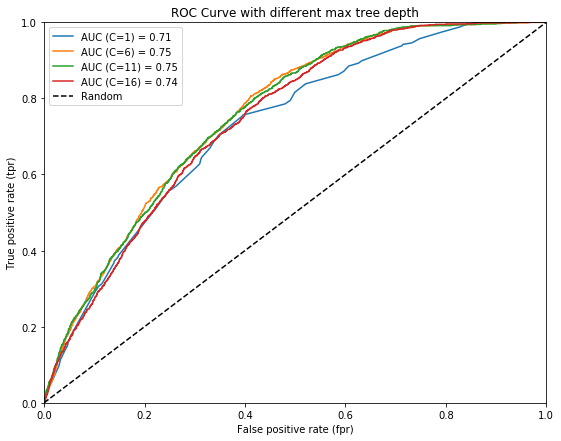

In [47]:
for c in np.arange(1,20,5):
    model = RandomForestClassifier(random_state=0,max_depth=c,class_weight='balanced')
    model.fit(X_train,Y_train)

    # Get the probability of Y_test records being = 1
    Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

    # Use the metrics.roc_curve function to get the true positive rate (tpr) and false positive rate (fpr)
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_test_probability_1)
    
    # Get the area under the curve (AUC)
    auc = np.mean(cross_val_score(model, X_sparse, Y, scoring="roc_auc"))

    # Plot the ROC curve
    plt.plot(fpr, tpr, label="AUC (C=" + str(c) + ") = " + str(round(auc, 2)))
    

plt.plot([0,1], [0,1], 'k--', label="Random")
plt.xlabel("False positive rate (fpr)")
plt.ylabel("True positive rate (tpr)")
plt.title("ROC Curve with different max tree depth")
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc=2)

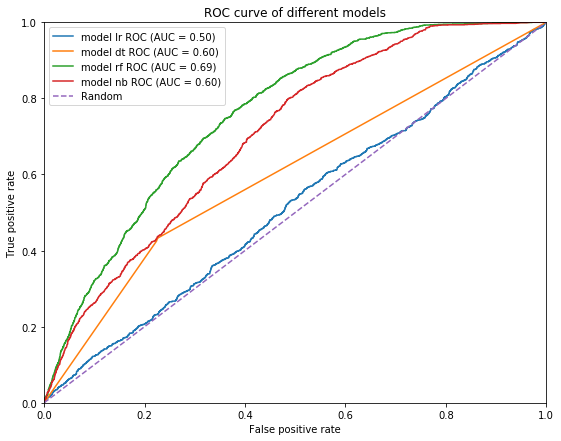

In [54]:

models =["lr","dt","rf","nb"]

for m in models:
    if m=="dt":
        model = DecisionTreeClassifier()
    elif m =="lr":
        model = LogisticRegression()
    elif m=="nb":
        model= BernoulliNB()  
    elif m=="svc":
        model = SVC()
    else:
        model = RandomForestClassifier(class_weight='balanced',random_state=0,max_depth=10)
        
    model.fit(X_train,Y_train)
    probabilities = model.predict_proba(X_test)
    roc_auc= metrics.roc_auc_score(Y_test, model.predict(X_test))


    fpr, tpr, thresholds = roc_curve(Y_test, probabilities[:, 1])

    plt.plot(fpr, tpr,label='model %s ROC (AUC = %0.2f)' % (m,roc_auc))


plt.title('ROC curve of different models')
plt.plot([0, 1], [0, 1], '--',label="Random")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc="upper left")
plt.show()

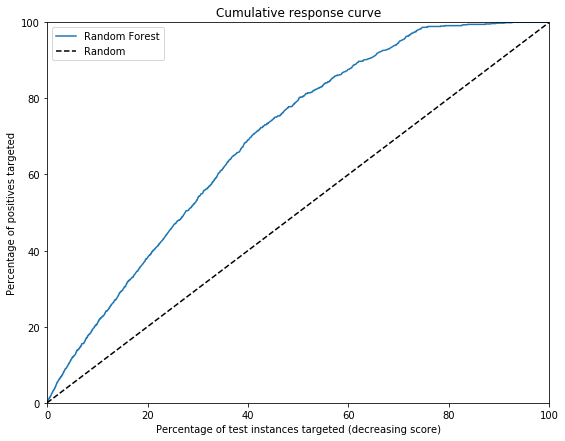

In [61]:

# Keep track of all output with the name of the models
xs = {}
ys = {}

# Instantiate the model
model = RandomForestClassifier(random_state=0,max_depth=5,class_weight='balanced')
model.fit(X_train,Y_train)

Y_test_predicted = model.predict(X_test)
Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_test_probability_1)
# How many users are above the current threshold?
n_targeted = []
for t in thresholds:
    n_targeted.append(np.sum(Y_test_probability_1 >= t))

# Turn these counts to percentages of users above the threshold
n_targeted = np.array(n_targeted)/float(len(Y_test))

# Store
xs = n_targeted * 100
ys = tpr * 100

plt.plot(n_targeted * 100, tpr * 100, label = "Random Forest")# * np.sum(Y_test)/float(len(Y_test)))

plt.plot([0,100], [0,100], 'k--', label="Random")
plt.xlabel("Percentage of test instances targeted (decreasing score)")
plt.ylabel("Percentage of positives targeted")
plt.xlim([0,100])
plt.ylim([0,100])
plt.title("Cumulative response curve")
plt.legend(loc=2)
plt.show()

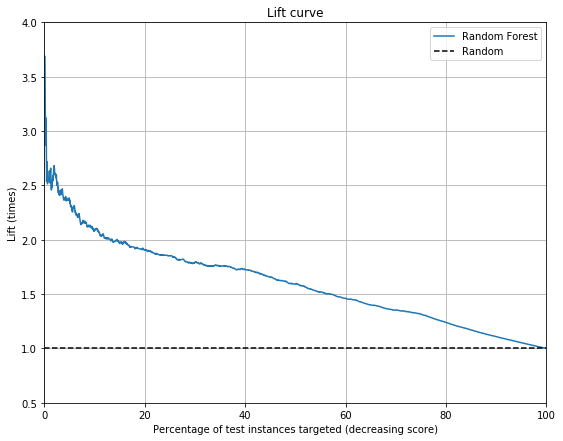

In [62]:




# Previously computed: n_targeted * 100
x_lift = xs
# Previously computed: tpr * 100
y_lift = ys/x_lift
plt.plot(x_lift, y_lift, label="Random Forest")

plt.plot([0,100], [1,1], 'k--', label="Random")
plt.xlabel("Percentage of test instances targeted (decreasing score)")
plt.ylabel("Lift (times)")
plt.title("Lift curve")
plt.legend()
plt.ylim([.5,4])
plt.xlim([0,100])
plt.grid()
plt.show()

In [130]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(Y_test, clf.predict(X_test))
cm

array([[3833, 2307],
       [ 572, 1647]])

In [134]:
classification_report(Y_test, clf.predict(X_test),target_names = ['0','1'])

'             precision    recall  f1-score   support\n\n          0       0.87      0.62      0.73      6140\n          1       0.42      0.74      0.53      2219\n\navg / total       0.75      0.66      0.68      8359\n'

In [74]:
data_new = pd.read_csv('./data/traindatafinal.csv')
data_drop = data_new.sort_values(by=['Leads Lead UUID',
                                     'Sales Transactions Is Gross Conversion (Yes / No)'],
                                 ascending=False).drop_duplicates(subset=['Leads Lead UUID'])

In [78]:
#missing value imputation:
temp = deepcopy(data_drop)
def missing_value_imputer(row):
    for c in cat_columns:
        if str(row[c])== 'nan':
            row[c] = 'missing'
        else:
            row[c] = row[c]
    for n in num_columns:
        if str(row[n])=='nan':
            row[n] = np.mean(temp[n])
        else:
            row[n] = row[n]
    return row
data_drop = data_drop.apply(missing_value_imputer,axis = 1)
data_drop

,Leads Zip Code,Leads Intended Storage Duration In Months,Leads Has Storage Plan Quote (Yes / No),Leads Is Chat Lead (Yes / No),Sales Transactions Is Gross Conversion (Yes / No),Attributions: Unified Tracking Unified Ops Sector,Attributions: Unified Tracking UTM Medium Categories,Leads Created Date Month,Leads Created Date Weekday,Leads Created Date Season,...,mean,median,population,homevalue,makespace,extraspace,privatecompanies,publicstorage,cubesmart,Leads Lead UUID
45377,60625,3,Yes,Yes,Yes,Chicago,Paid Social/ Display,1,6,1,...,73673.40000,107481.00000,78651.00000,237.966667,0.776023,1.676690,2.110609,1.947812,2.063515,e32a1067d3cc41adb1d23bc4cc54f5d4
45376,10011,3,No,No,Yes,New York,Organic/ No UTM,12,1,1,...,120292.71430,138692.42860,50984.00000,1617.166667,2.027517,2.096468,2.275000,1.947812,2.063515,e327b2ded4714438965a53add5111e4f
45374,10016,24,No,No,No,New York,SEM,6,1,2,...,105939.50000,195232.75000,54183.00000,1225.300000,1.958554,2.096468,2.250000,1.947812,2.063515,e32722e0765f4b0d97443ac30a48bfd6
45372,11208,3,No,No,Yes,New York,SEM,12,1,1,...,53810.18182,40073.54545,94469.00000,285.016667,1.778669,2.096468,2.564144,1.947812,2.063515,e32548f2194b44a09c6b4a7f5c9f9cac
45370,10011,4,No,No,No,New York,Organic/ No UTM,4,4,2,...,120292.71430,138692.42860,50984.00000,1617.166667,2.027517,2.096468,2.275000,1.947812,2.063515,e32506f17bcb49b38f79000a66ece6e5
45369,10027,6,Yes,No,No,New York,SEM,6,6,2,...,61498.75000,52652.62500,59707.00000,818.416667,1.868439,1.927849,2.110609,1.947812,2.063515,e322f312c83e4da48ad631b1775119a7
45368,60612,6,No,No,No,Chicago,Paid Social/ Display,11,5,4,...,30057.33333,20783.00000,33472.00000,150.366667,0.615762,2.096468,2.110609,1.697333,2.063515,e322405379b74f41a28532754a31c426
45365,60653,3,Yes,No,Yes,Chicago,SEM,5,3,2,...,72727.80000,54267.60000,29908.00000,142.583333,0.615762,2.096468,0.848742,0.821474,2.063515,e31d76a55fb04ce4b14ef7e157e4c089
45363,60619,6,Yes,No,Yes,Chicago,SEM,1,6,1,...,50641.87500,71549.37500,63825.00000,108.566667,0.615762,1.375896,1.463953,1.328458,2.063515,e31a4a827f994d74a37278ddf5b6b104
45362,10013,3,No,No,No,New York,Paid Social/ Display,5,3,2,...,113722.50000,100142.00000,27700.00000,0.000000,2.027517,2.096468,2.250000,1.947812,2.063515,e3172181eaf240ab9bfe196469803d6c


In [81]:
len(data_drop)

33434

In [82]:
data_drop.to_csv('./data/drop_dup.csv',index=False)